## Import Packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from numba import njit

In [2]:
# Python Version
import sys 
sys.path.append('../../')
import evaLEs.LE as ly
# Python + Numba Version
import evaLEs.numbaLE as nly

## Definition of Dynamical System with Numba

You can use the @njit decorator for numbaLE

In [3]:
@njit
def ODE(t, val, p):
    """
    Define the increment of the Dyn. Syst. in the scipy.integrate.ode way
    """
    x, y = val
    diff = [x*p[0] - y, y*p[1] - x] 
    return np.array(diff)

@njit
def J(t, val, p):
    """
    The Jacobian of the system (evaluated by you)
    """
    D = len(val)
    J = - np.ones((D,D)) + np.eye(D) * ( p + 1 )
    return J

## Define parameters, temporal interval and initial conditions:

In [4]:
p = np.array([-0.01, -0.03], dtype=np.float64)
init = np.array([0.1, 0.1], dtype=np.float64)

ttrans = np.arange(0.0, 100, 0.1, dtype=np.float64)
t = np.arange(0.0, 100, 0.01, dtype=np.float64)

## Evaluate the Lyapunov Spectrum

In [5]:
start = time.time()
LE, sol = nly.computeLE(ODE, J, init, t, p, ttrans)
print(f'Exec Time: {time.time()-start}')
print(f'The LEs are: {LE[-1]}')

Exec Time: 4.918744087219238
The LEs are: [ 0.97663367 -1.01663367]


Note that the first execution will be slower than the second: let's try another time!

In [6]:
start = time.time()
LE, sol = nly.computeLE(ODE, J, init, t, p, ttrans)
print(f'Exec Time: {time.time()-start}')
print(f'The LEs are: {LE[-1]}')

Exec Time: 0.043151140213012695
The LEs are: [ 0.97663367 -1.01663367]


You can osserve the convergence of the LEs during the algorithm:

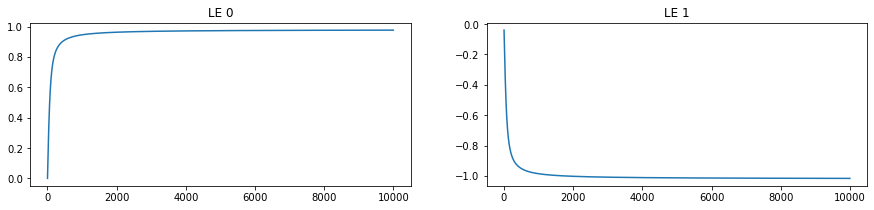

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
for i, (ax, le) in enumerate(zip(axs.flat, LE.T)):
    ax.plot(le)
    ax.set_title(f'LE {i}')

## Definition of Dynamical System just in Python

In [8]:
def ODE(t, val, p):
    """
    Define the increment of the Dyn. Syst. in the scipy.integrate.ode way
    """
    x = val[0]
    y = val[1]
    diff = [x*p[0] - y, y*p[1] - x] 
    return np.array(diff)

def J(t, val, p):
    """
    The Jacobian of the system (evaluated by you)
    """
    D = len(val)
    J = - np.ones((D,D)) + np.eye(D) * ( p + 1 )
    return J

## Evaluate the Lyapunov Spectrum

In [9]:
start = time.time()
LE = ly.computeLE(ODE, J, init, t, p, ttrans)
print(f'Exec Time: {time.time()-start}')
print(f'The LEs are: {LE[-1]}')

Exec Time: 1.335341215133667
The LEs are: [ 0.97663367 -1.01663367]


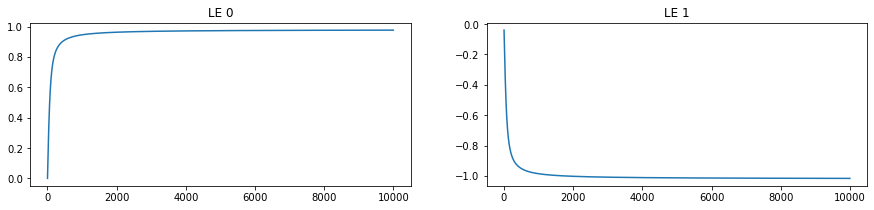

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
for i, (ax, le) in enumerate(zip(axs.flat, LE.T)):
    ax.plot(le)
    ax.set_title(f'LE {i}')

## Advanced Examples

### Lorenz Attractor

The Lorenz system is defined as:

$$\begin{cases}
\dot{x} = \sigma(y-x)\\
\dot{y} = x(\rho-z)-y\\
\dot{z} = xy-\beta z
\end{cases}$$

We can compute the Lyapunov exponent in case of the famous set of parameters: $(\sigma, \rho, \beta) = (10, 28, 8/3)$ starting from a random initial position.

In [30]:
@njit
def Lorenz(_, val, p): # no need of the variable t
    """
    Define the increment of the Dyn. Syst. in the scipy.integrate.ode way
    """
    x, y, z = val
    sigma, rho, beta = p
    diff = [sigma*(y-x), x*(rho-z)-y,x*y - beta*z] 
    return np.array(diff)

@njit
def JLorenz(t, val, p):
    """
    The Jacobian of the system (evaluated by you)
    """
    x, y, z = val
    sigma, rho, beta = p
    J = [[-sigma, sigma, 0    ], 
         [rho-z, -1   , -x   ],
         [y     , x    , -beta]]
    return np.array(J)

In [31]:
sigma = 10
rho = 28 
beta = 8/3
p = np.array([sigma, rho, beta], dtype=np.float64)
init = np.random.random(3)

ttrans = np.arange(0.0, 5000, 0.01, dtype=np.float64)
t = np.arange(0.0, 300, 0.01, dtype=np.float64)

start = time.time()
LE, s = nly.computeLE(Lorenz, JLorenz, init, t, p,ttrans)
print(f'Exec Time: {time.time()-start}')
print(f'The LEs are: {LE[-1]}')

Exec Time: 3.9550540447235107
The LEs are: [ 9.07900692e-01 -4.96495991e-03 -1.45694998e+01]


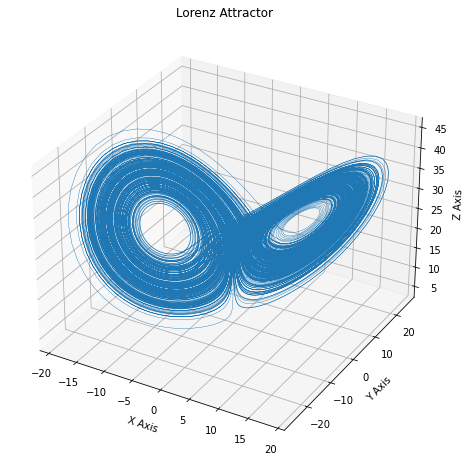

In [32]:
# Plot
xs = s[:,0]
ys = s[:,1]
zs = s[:,2]

ax = plt.figure(figsize = (8, 8)).add_subplot(projection='3d')

ax.plot(xs, ys, zs, lw=0.4)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

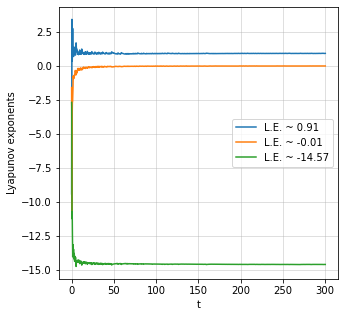

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, le in enumerate(LE.T):
    ax.plot(t[1:], le, label = f'L.E. ~ {LE[-1,i]:.2f}')
ax.set_ylabel('Lyapunov exponents')
ax.set_xlabel('t')
ax.grid(alpha = 0.5)
plt.legend()
plt.show()

### Quality check of the algorithm
The sum of the Lyapunov exponents must be equal to the sum of the diagonal elements of the jacobian:

$$Tr(J) = -\sigma - 1 - \beta$$

In [15]:
Tr = - sigma - 1 - beta
print("Sum of diag. elements = ", Tr)

Sum of diag. elements =  -13.666666666666666


In [16]:
SumLyap = np.sum(LE[-1, :])
print('Sum of Lyapunov Exponents = ', SumLyap)

Sum of Lyapunov Exponents =  -13.666563901674888


### Rossler attractor


$$\begin{cases}
\dot{x} = -y-z\\
\dot{y} = x + ay\\
\dot{z} = b + z(x-c)
\end{cases}$$


In [44]:
@njit
def Rossler(_, val, p): # no need for variable t
    """
    Define the increment of the Dyn. Syst. in the scipy.integrate.ode way
    """
    x, y, z = val
    a, b, c = p
    diff = [- y - z, x + a * y, b + z * (x - c)] 
    return np.array(diff)

@njit
def JRossler(_, val, p):
    """
    The Jacobian of the system (evaluated by you)
    """
    x, y, z = val
    a, b, c = p
    J = [[0.    , -1.  , -1.   ], 
         [1.    , a    , 0.    ],
         [z     , 0.   , x - c ]]
    return np.array(J)

In [47]:
a = 0.2
b = 0.2
c = 5.7
p = np.array([a, b, c], dtype=np.float64)
init = np.random.random(3).astype(np.float64)

ttrans = np.arange(0.0, 5000, 0.01, dtype=np.float64)
t = np.arange(0.0, 3000, 0.01, dtype=np.float64)

start = time.time()
LE, s = nly.computeLE(Rossler, JRossler, init, t, p, ttrans)
print(f'Exec Time: {time.time()-start}')
print(f'The LEs are: {LE[-1]}')

Exec Time: 1.750584363937378
The LEs are: [ 7.07056327e-02  1.18526517e-03 -5.39109601e+00]
